# Pysersic Walkthrough: Fitting a single source

In this tutorial we'll walk through how to set up and fit a galaxy using `pysersic`. 

## Loading the data

We'll be using three galaxies imaged by HSC for this example. The 4 needed inputs to perform a fit are
 - im: the image itself
 - mask: a mask indicating pixels which should not be included in the fit
 - sig: a map of pixel uncertainties 
 - psf: a map of the PSF (for now, only one psf can be used).

In [1]:
import numpy as np 
def load_data(n):
    im = np.load(f'examp_gals/gal{n}_im.npy')
    mask = np.load(f'examp_gals/gal{n}_mask.npy')
    sig = np.load(f'examp_gals/gal{n}_sig.npy')
    psf = np.load(f'examp_gals/gal{n}_psf.npy')
    return im,mask,sig,psf 

im,mask,sig,psf = load_data(1)

Let's visualize our galaxy, just to see what we're working with. You can do this any way you like. A convenience function is provided:

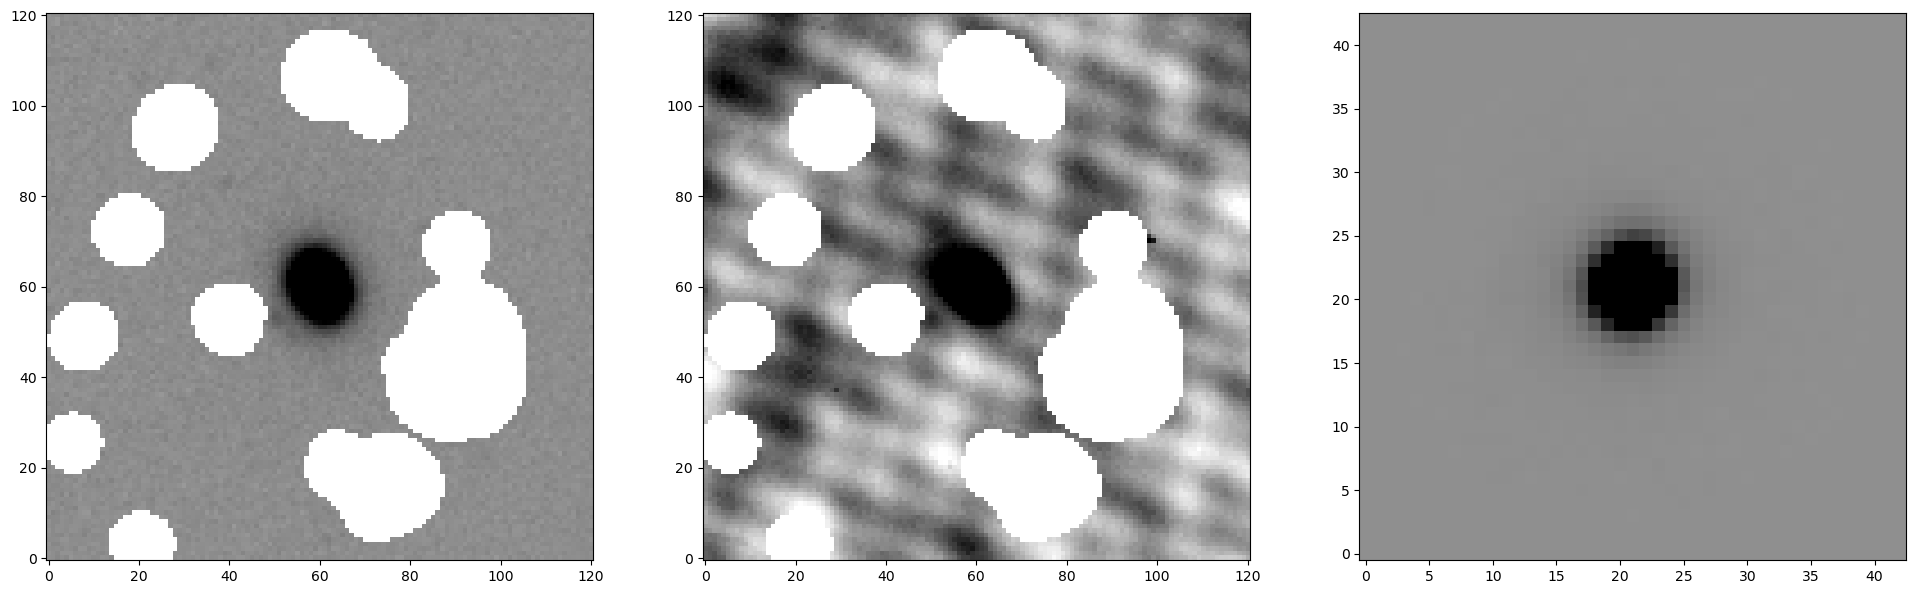

In [2]:
from pysersic.utils.visualization import plot_image

fig, ax = plot_image(im,mask,sig,psf)

## Fitting 

Now that we have our galaxy to fit, we can get set up with `pysersic`. 

Because we are fitting a single source, we'll want to initialize a `pysersic.FitSingle` object. For a field with multiple object, we would use `pysersic.FitMulti`. 

Additionally, we will need to set up a `pysersic.PysersicSourcePrior` object to handle the priors for the fit. (Again, using Source as we have a single galaxy to fit). 



The Source Prior takes two initial arguments, the profile type, whose options at current are
- sersic
- double sersic 
- point source
- exponential
- devaucoleurs 

and the sky_type, which indicates whether to fit the sky background, either with
- none (no fitting)
- flat (a single offset), or 
- tilted-plane 

At this point, we would need to write down priors for all of the fit parameters of a Sersic. However, there is an `autoprior` utility function that can more or less do this for us:


In [3]:
from pysersic.priors import autoprior 

prior = autoprior(im,profile_type='sersic',sky_type='flat',mask=mask)

The `autoprior()` function has a built-in choice about the prior functions to use for each sersic parameter, and then makes estimates for the parameters of those priors off of the image itself. We can print our prior to see what it chose:

In [4]:
prior

Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 1909.80, sigma = 87.40
r_eff ---  Truncated Normal w/ mu = 1.40, sigma = 1.18, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Custom prior of type: <class 'numpyro.distributions.directional.VonMises'>
n ---  Uniform between: 0.50 -> 8.00
xc ---  Normal w/ mu = 60.02, sigma = 1.00
yc ---  Normal w/ mu = 60.06, sigma = 1.00

As we can see, this function used properties of the input image to make reasonable priors for the fit parameters. For now, let's continue, and in another example, we'll set some priors manually. 

Armed with our prior object, we can set up our `FitSingle` fitter. At this stage, we need to choose a `loss_func()`, which is used to evaluate the models to the data. For this example, we'll import the `student_t_loss()` from the `utils.loss` submodule. We recommend starting with student t, as it is less sensitive to outliers than a gaussian loss.

In [5]:
from pysersic import FitSingle
from pysersic.utils.loss import student_t_loss

fitter = FitSingle(data=im,rms=sig,mask=mask,psf=psf,prior=prior,loss_func=student_t_loss)

The set of currently implemented loss functions are:
- cash loss (Cash 1979)
- fractional gaussian loss 
- gaussian loss with a systematic offset
- student t loss
- student t loss with a free nu parameter
- student t loss with free nu and a systematic component. 

See the page on `Loss Functions` to learn more about these choices. 

With a fitter object created, we are now free to carry out a fit. 

## MAP Parameters
Before we jump all the way into *sampling*, it's worth noting that we can also retrieve a prediction for the best fit model very quickly, using SVI (stochastic variational inference). 

The simplest, barebones way to do this is to run the `fitter.find_MAP()` method. This will produce a point-estimate of the parameters with no attempt to estimate the posterior distribution (i.e., the closest thing to running GALFIT). Unlike the rest of the methods we'll show below, this does not produce a fancy `PySersicResult` object; it simply returns a dictionary with the values:

In [6]:
map_params = fitter.find_MAP()

 11%|█         | 533/5000 [00:01<00:13, 329.69it/s, Round = 2,step_size = 1.0e-04 loss: -1.648e+04]


In [7]:
map_params

{'xc': 60.0442,
 'yc': 60.0545,
 'flux': 1708.25,
 'r_eff': 3.2297,
 'n': 1.79315,
 'ellip': 0.262952,
 'theta': -1.09263,
 'sky_back': 0.0109143,
 'model': array([[0.01091457, 0.01091465, 0.01091446, ..., 0.01091507, 0.01091499,
         0.01091513],
        [0.01091505, 0.01091498, 0.01091521, ..., 0.01091486, 0.01091523,
         0.01091529],
        [0.01091534, 0.01091573, 0.01091594, ..., 0.01091492, 0.01091525,
         0.01091572],
        ...,
        [0.0109141 , 0.01091444, 0.01091517, ..., 0.01091253, 0.01091302,
         0.01091319],
        [0.0109146 , 0.01091502, 0.01091522, ..., 0.01091376, 0.01091385,
         0.0109141 ],
        [0.01091494, 0.0109149 , 0.01091509, ..., 0.01091429, 0.01091445,
         0.01091433]], dtype=float32)}

Without compilation (i.e., after being run once), running this took ~4 seconds on the laptop on which this notebook was run (on CPU). Including compilation, it is closer to ~8s. 

# Posterior *Estimation*

Taking one step up from simply retrieving the MAP, we can make an *estimate* of the posterior around the MAP using one of several available methods. 

At present, these are `laplace`, in which the MAP is found, then the posterior is assumed to be a gaussian around it, and `svi-flow`, in which a normalizing flow is trained to estimate the posterior and is sampled from directly. 

Both methods are relatively fast, with `laplace` taking 8-10 seconds and `svi-flow` taking around 45 seconds. 


In [8]:
res = fitter.estimate_posterior(method='laplace')

  6%|▌         | 288/5000 [00:00<00:11, 407.35it/s, Round = 2,step_size = 1.0e-04 loss: -1.648e+04]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [9]:
res2 = fitter.estimate_posterior(method='svi-flow')


  5%|▍         | 903/20000 [00:17<06:12, 51.23it/s, Round = 2,step_size = 1.0e-04 loss: -1.645e+04]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


As a note, these fit methods return the results object, but we can access it anytime by calling the `fitter.svi_results` attribute. But a given `fitter` can only have one `svi_results` and one `sampling_results` at a time, hence the use of `res2` above to extract it separately

For any run, we can use the `.summary()` method of the `fitter.svi_results` to see a dataframe output.

In [12]:
res2

mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
ellip        0.263  0.002     0.259     0.267      0.000     0.00    1039.0   
flux      1708.148  3.839  1700.738  1715.088      0.127     0.09     915.0   
n            1.795  0.019     1.761     1.830      0.001     0.00     892.0   
r_eff        3.230  0.012     3.209     3.253      0.000     0.00     923.0   
sky_back     0.011  0.001     0.010     0.012      0.000     0.00    1003.0   
theta        2.049  0.005     2.039     2.059      0.000     0.00    1012.0   
xc          60.044  0.005    60.035    60.052      0.000     0.00     968.0   
yc          60.055  0.005    60.046    60.064      0.000     0.00    1074.0   

          ess_tail  r_hat  
ellip        990.0    NaN  
flux         904.0    NaN  
n            626.0    NaN  
r_eff        883.0    NaN  
sky_back     967.0    NaN  
theta        864.0    NaN  
xc           893.0    NaN  
yc           988.0    NaN

In [14]:
fitter.svi_results.summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
ellip        0.263  0.002     0.259     0.267      0.000     0.00    1039.0   
flux      1708.148  3.839  1700.738  1715.088      0.127     0.09     915.0   
n            1.795  0.019     1.761     1.830      0.001     0.00     892.0   
r_eff        3.230  0.012     3.209     3.253      0.000     0.00     923.0   
sky_back     0.011  0.001     0.010     0.012      0.000     0.00    1003.0   
theta        2.049  0.005     2.039     2.059      0.000     0.00    1012.0   
xc          60.044  0.005    60.035    60.052      0.000     0.00     968.0   
yc          60.055  0.005    60.046    60.064      0.000     0.00    1074.0   

          ess_tail  r_hat  
ellip        990.0    NaN  
flux         904.0    NaN  
n            626.0    NaN  
r_eff        883.0    NaN  
sky_back     967.0    NaN  
theta        864.0    NaN  
xc           893.0    NaN  
yc           988.0    NaN

And we can create a model image using the best-fit (median) posterior parameters:

In [19]:
mod = fitter.svi_results.get_median_model()

This mod is a tuple containing the median model parameters, and the actual model image associated with it:

In [24]:
mod

(ellip          0.261178
 flux        1707.892822
 n              1.794813
 r_eff          3.244310
 sky_back       0.010505
 theta          2.050360
 xc            60.045799
 yc            60.053051
 dtype: float64,
 array([[0.01050574, 0.01050653, 0.0105067 , ..., 0.01050421, 0.01050462,
         0.01050547],
        [0.01050644, 0.01050691, 0.01050699, ..., 0.0105041 , 0.0105051 ,
         0.01050589],
        [0.01050695, 0.01050735, 0.01050678, ..., 0.01050473, 0.01050567,
         0.01050677],
        ...,
        [0.01050459, 0.01050564, 0.01050706, ..., 0.01050363, 0.01050317,
         0.01050313],
        [0.01050535, 0.01050651, 0.01050739, ..., 0.01050364, 0.0105034 ,
         0.01050406],
        [0.01050593, 0.01050666, 0.01050744, ..., 0.01050352, 0.01050392,
         0.01050446]], dtype=float32))

We can then use the `plot_residual` function to quickly compare model to the data:

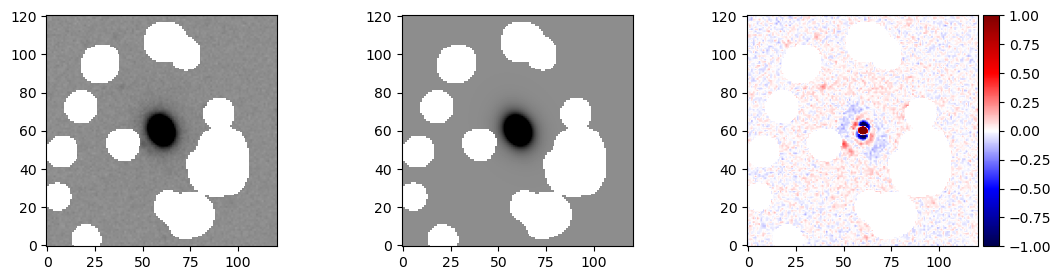

In [25]:
from pysersic.utils.visualization import plot_residual
fig, ax = plot_residual(im,mod[1],mask=mask,vmin=-1,vmax=1)

## Sampling 

Let's now try to sample. Here, we use the efficiency of No U-turn sampling plus the jit-compiled nature of the codebase to generate e.g., 4000 samples relatively quickly (~1-2min).

We can run the `fitter.sample()` method with no arguments, which will default to 2000 samples in 2 chains. But `sample()` will take any `**kwargs` to be passed to the `mcmc.NUTS()` sampler under the hood. The `fitter.sample()` method returns a new instance of a `PySersicResults` object, but will also store that new result in an attribute `fitter.sampling_results`, so we don't explicitly have to define a name here:

In [26]:
fitter.sample()

/Users/ipasha/Dropbox/github/pysersic/pysersic/pysersic.py:137: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.sampler =infer.MCMC(infer.NUTS(model,init_strategy=init_strategy, **sampler_kwargs),num_chains=num_chains, num_samples=num_samples, num_warmup=num_warmup,  **mcmc_kwargs)
sample: 100%|██████████| 2000/2000 [00:36<00:00, 54.14it/s, 7 steps of size 4.45e-01. acc. prob=0.91] 


PySersicResults object for pysersic fit of type: sampling

If we want to see the reuslts, we can retrieve an arviz summary table the same way as before, but this time retrieving the sampling results:

In [27]:
sampling_res = fitter.sampling_results
sampling_res.summary()

mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
ellip        0.263  0.002     0.258     0.267      0.000    0.000    1805.0   
flux      1708.031  4.069  1700.304  1715.380      0.106    0.075    1474.0   
n            1.793  0.020     1.757     1.831      0.001    0.000    1434.0   
r_eff        3.229  0.012     3.206     3.253      0.000    0.000    1867.0   
sky_back     0.011  0.001     0.010     0.012      0.000    0.000    2329.0   
theta        2.049  0.005     2.039     2.059      0.000    0.000    2475.0   
xc          60.044  0.005    60.035    60.054      0.000    0.000    3204.0   
yc          60.055  0.006    60.045    60.065      0.000    0.000    2915.0   

          ess_tail  r_hat  
ellip       1290.0    1.0  
flux        1562.0    1.0  
n           1730.0    1.0  
r_eff       1602.0    1.0  
sky_back    1418.0    1.0  
theta       1367.0    1.0  
xc          1541.0    1.0  
yc          1454.0    1.0

As before, we can render out the median model, but now specifying we want to use the sampling results:

In [28]:
mod_sampling = sampling_res.get_median_model()


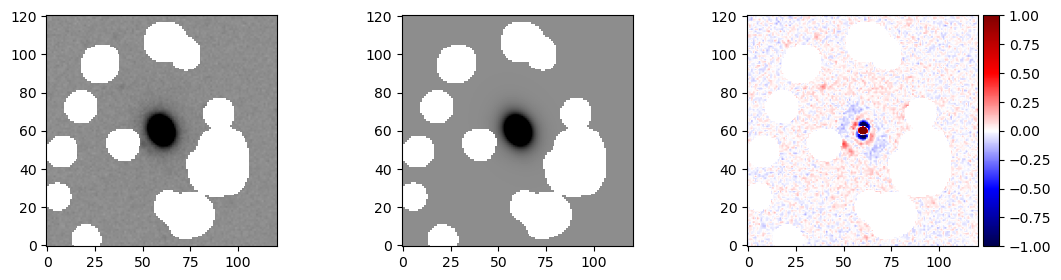

In [29]:
fig, ax = plot_residual(im,mod_sampling[1],mask=mask,vmin=-1,vmax=1)

## Other Diagnostics and Visualizations

Below we cover a few diagnostics we can look at. 

We can, for example, create corner plots for either the SVI results or sampling results:

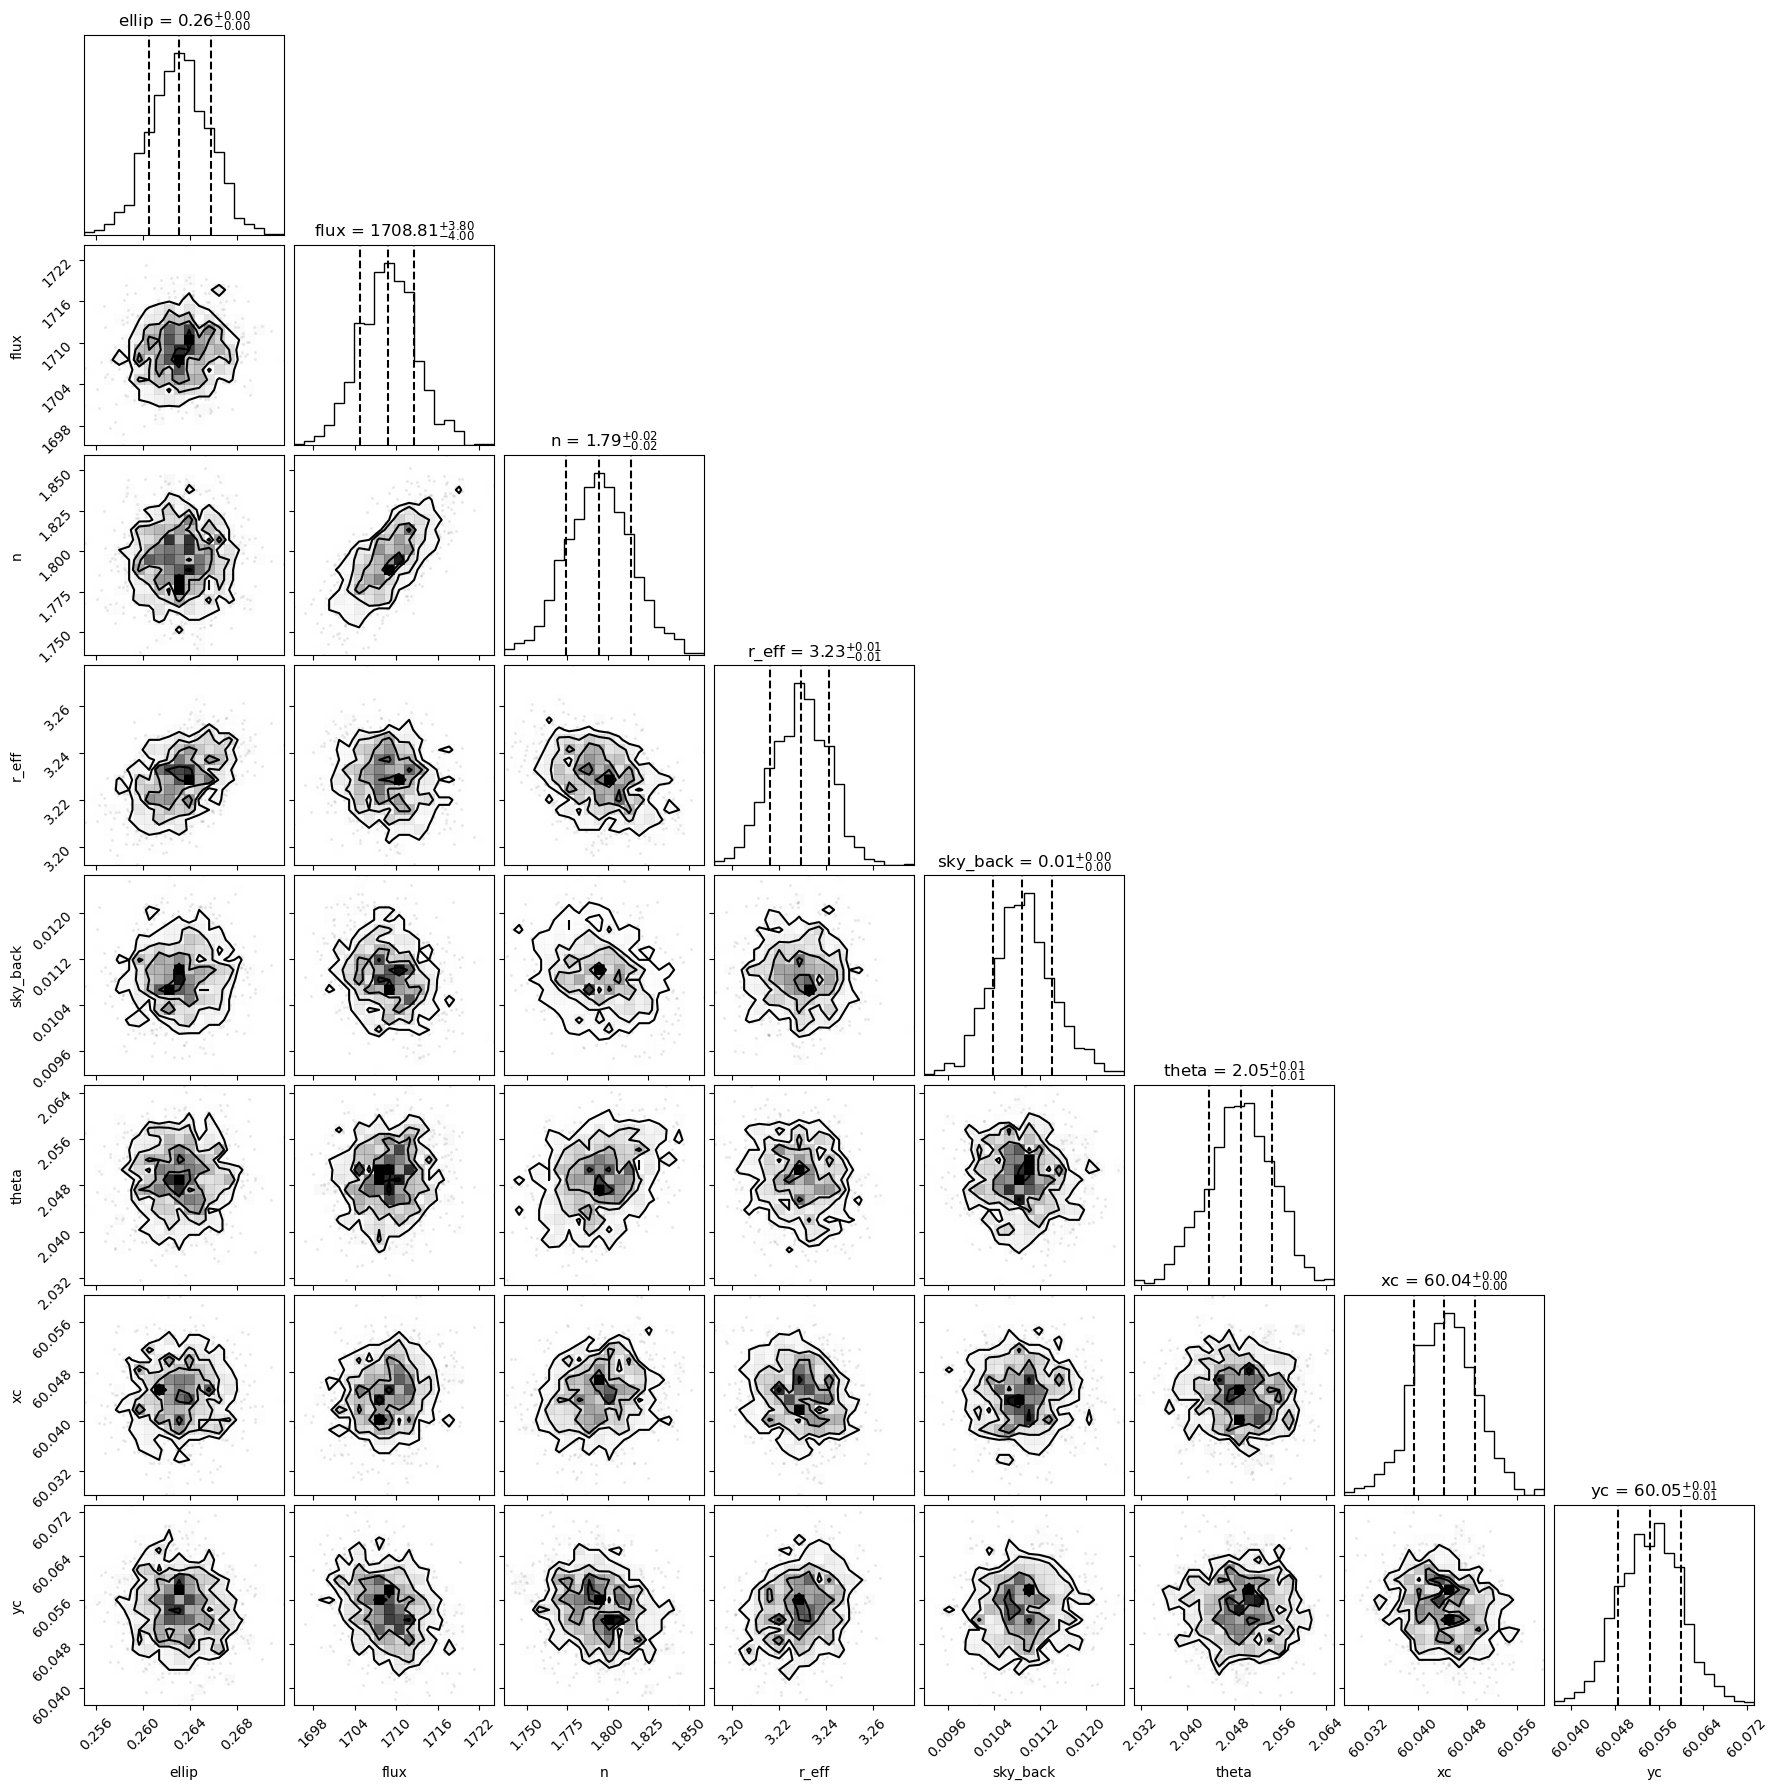

In [16]:
fig = fitter.svi_results.corner()

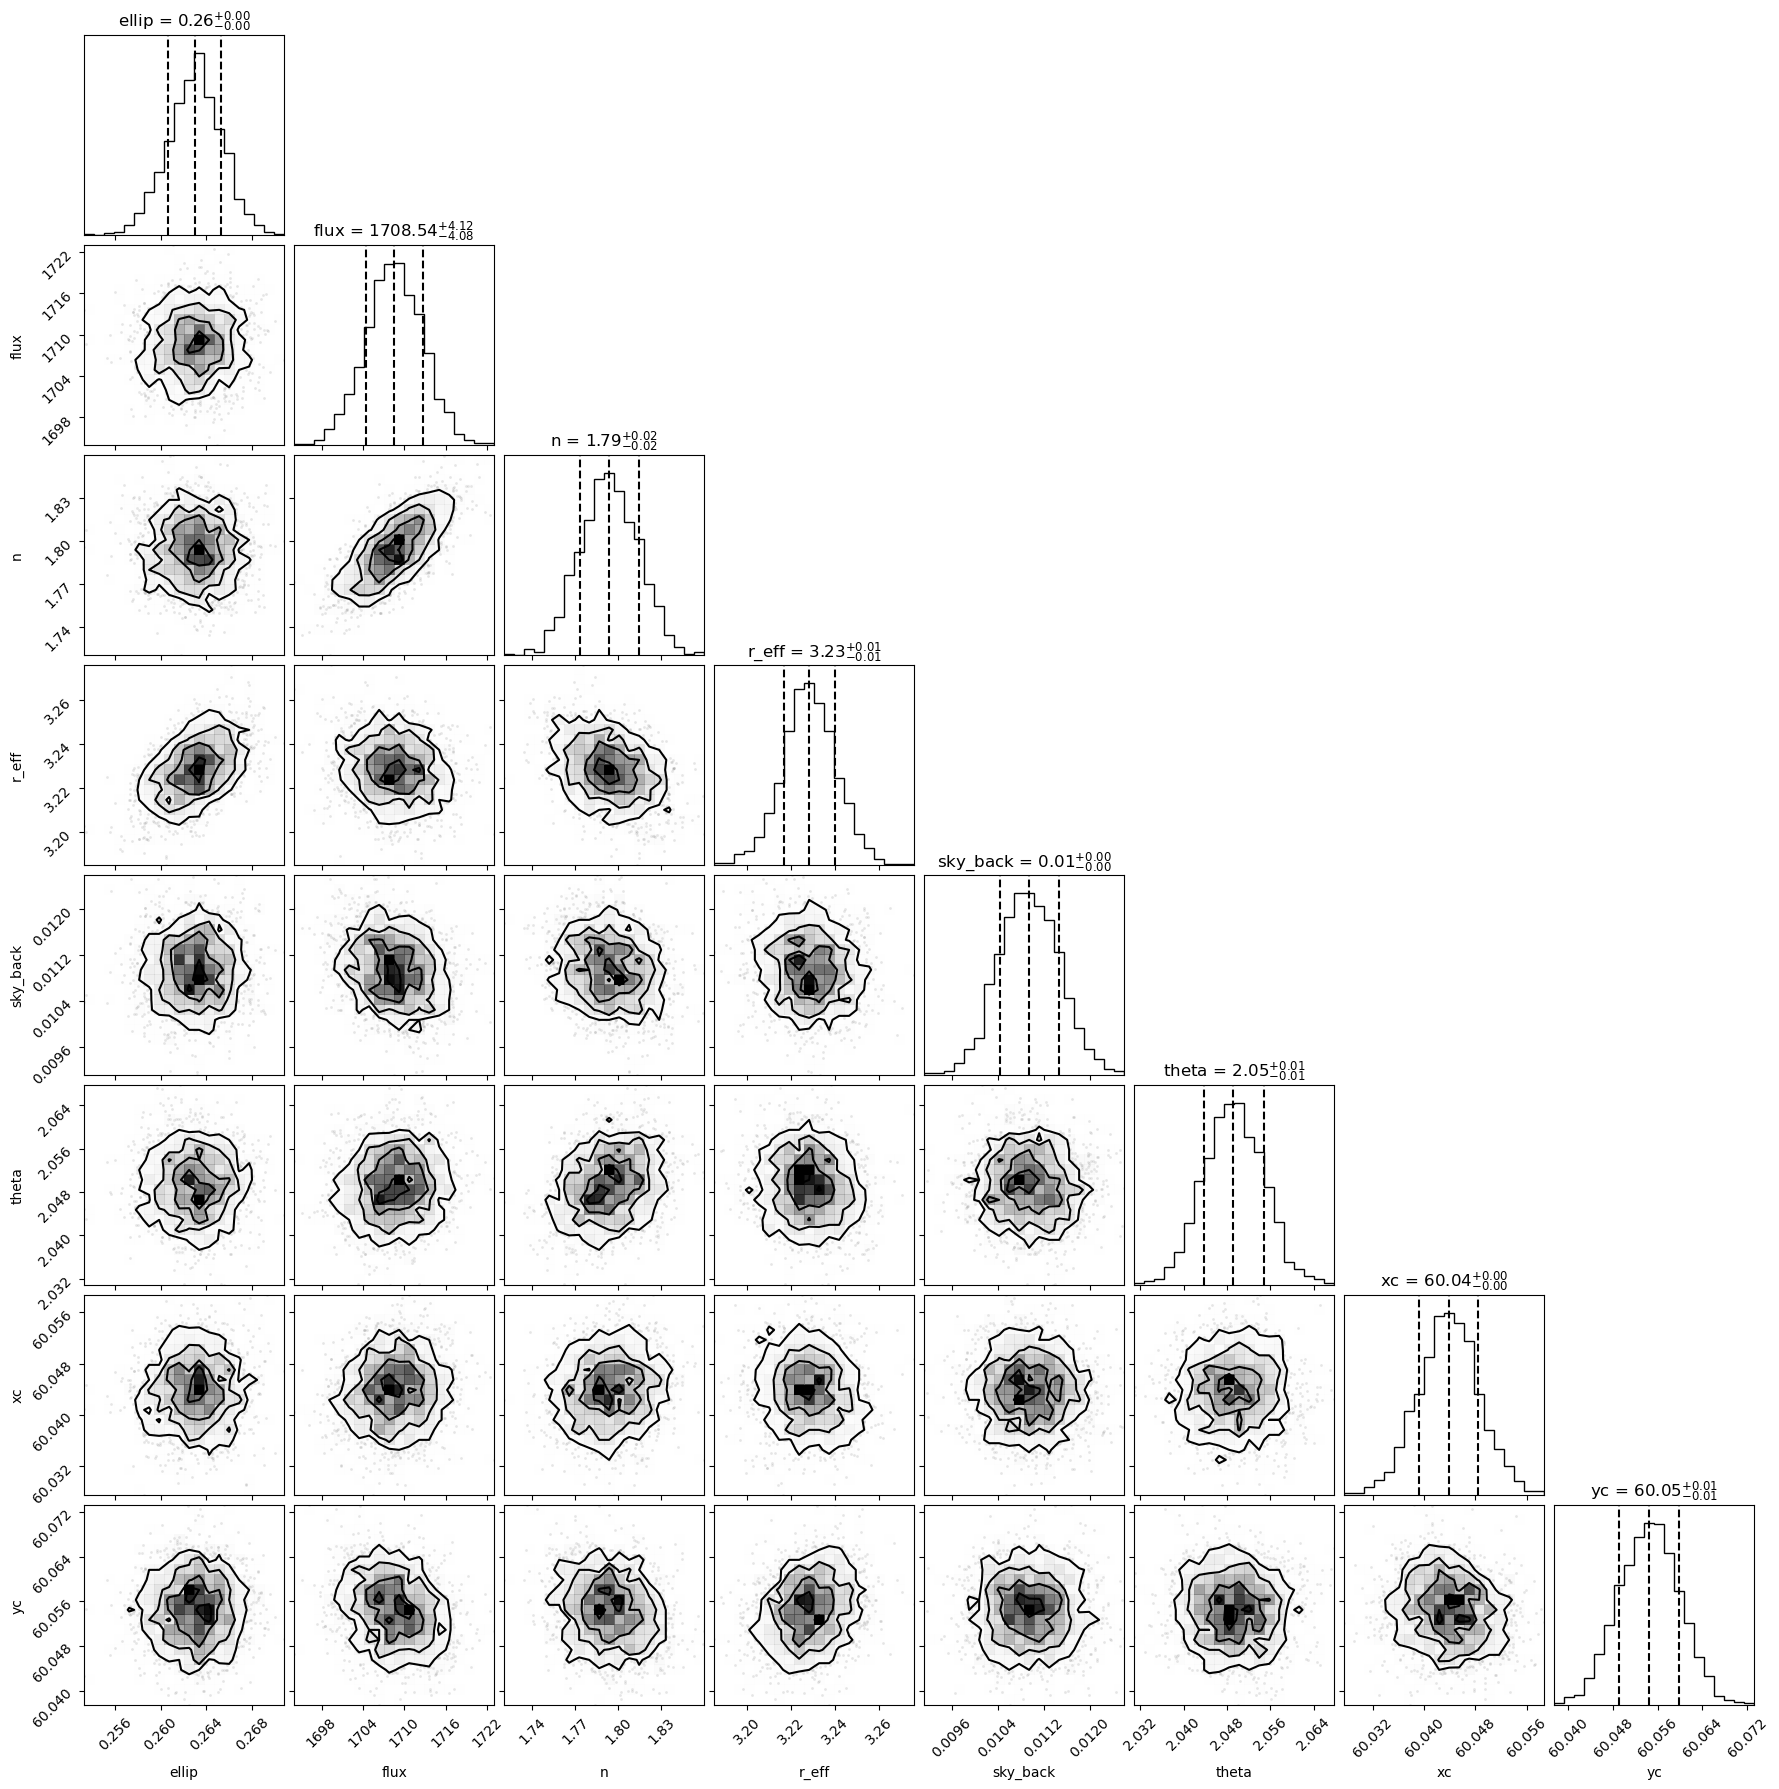

In [17]:
fig = fitter.sampling_results.corner()

It is relatively easy with the `corner.py` package to overplot both on each other to see how similar they are:

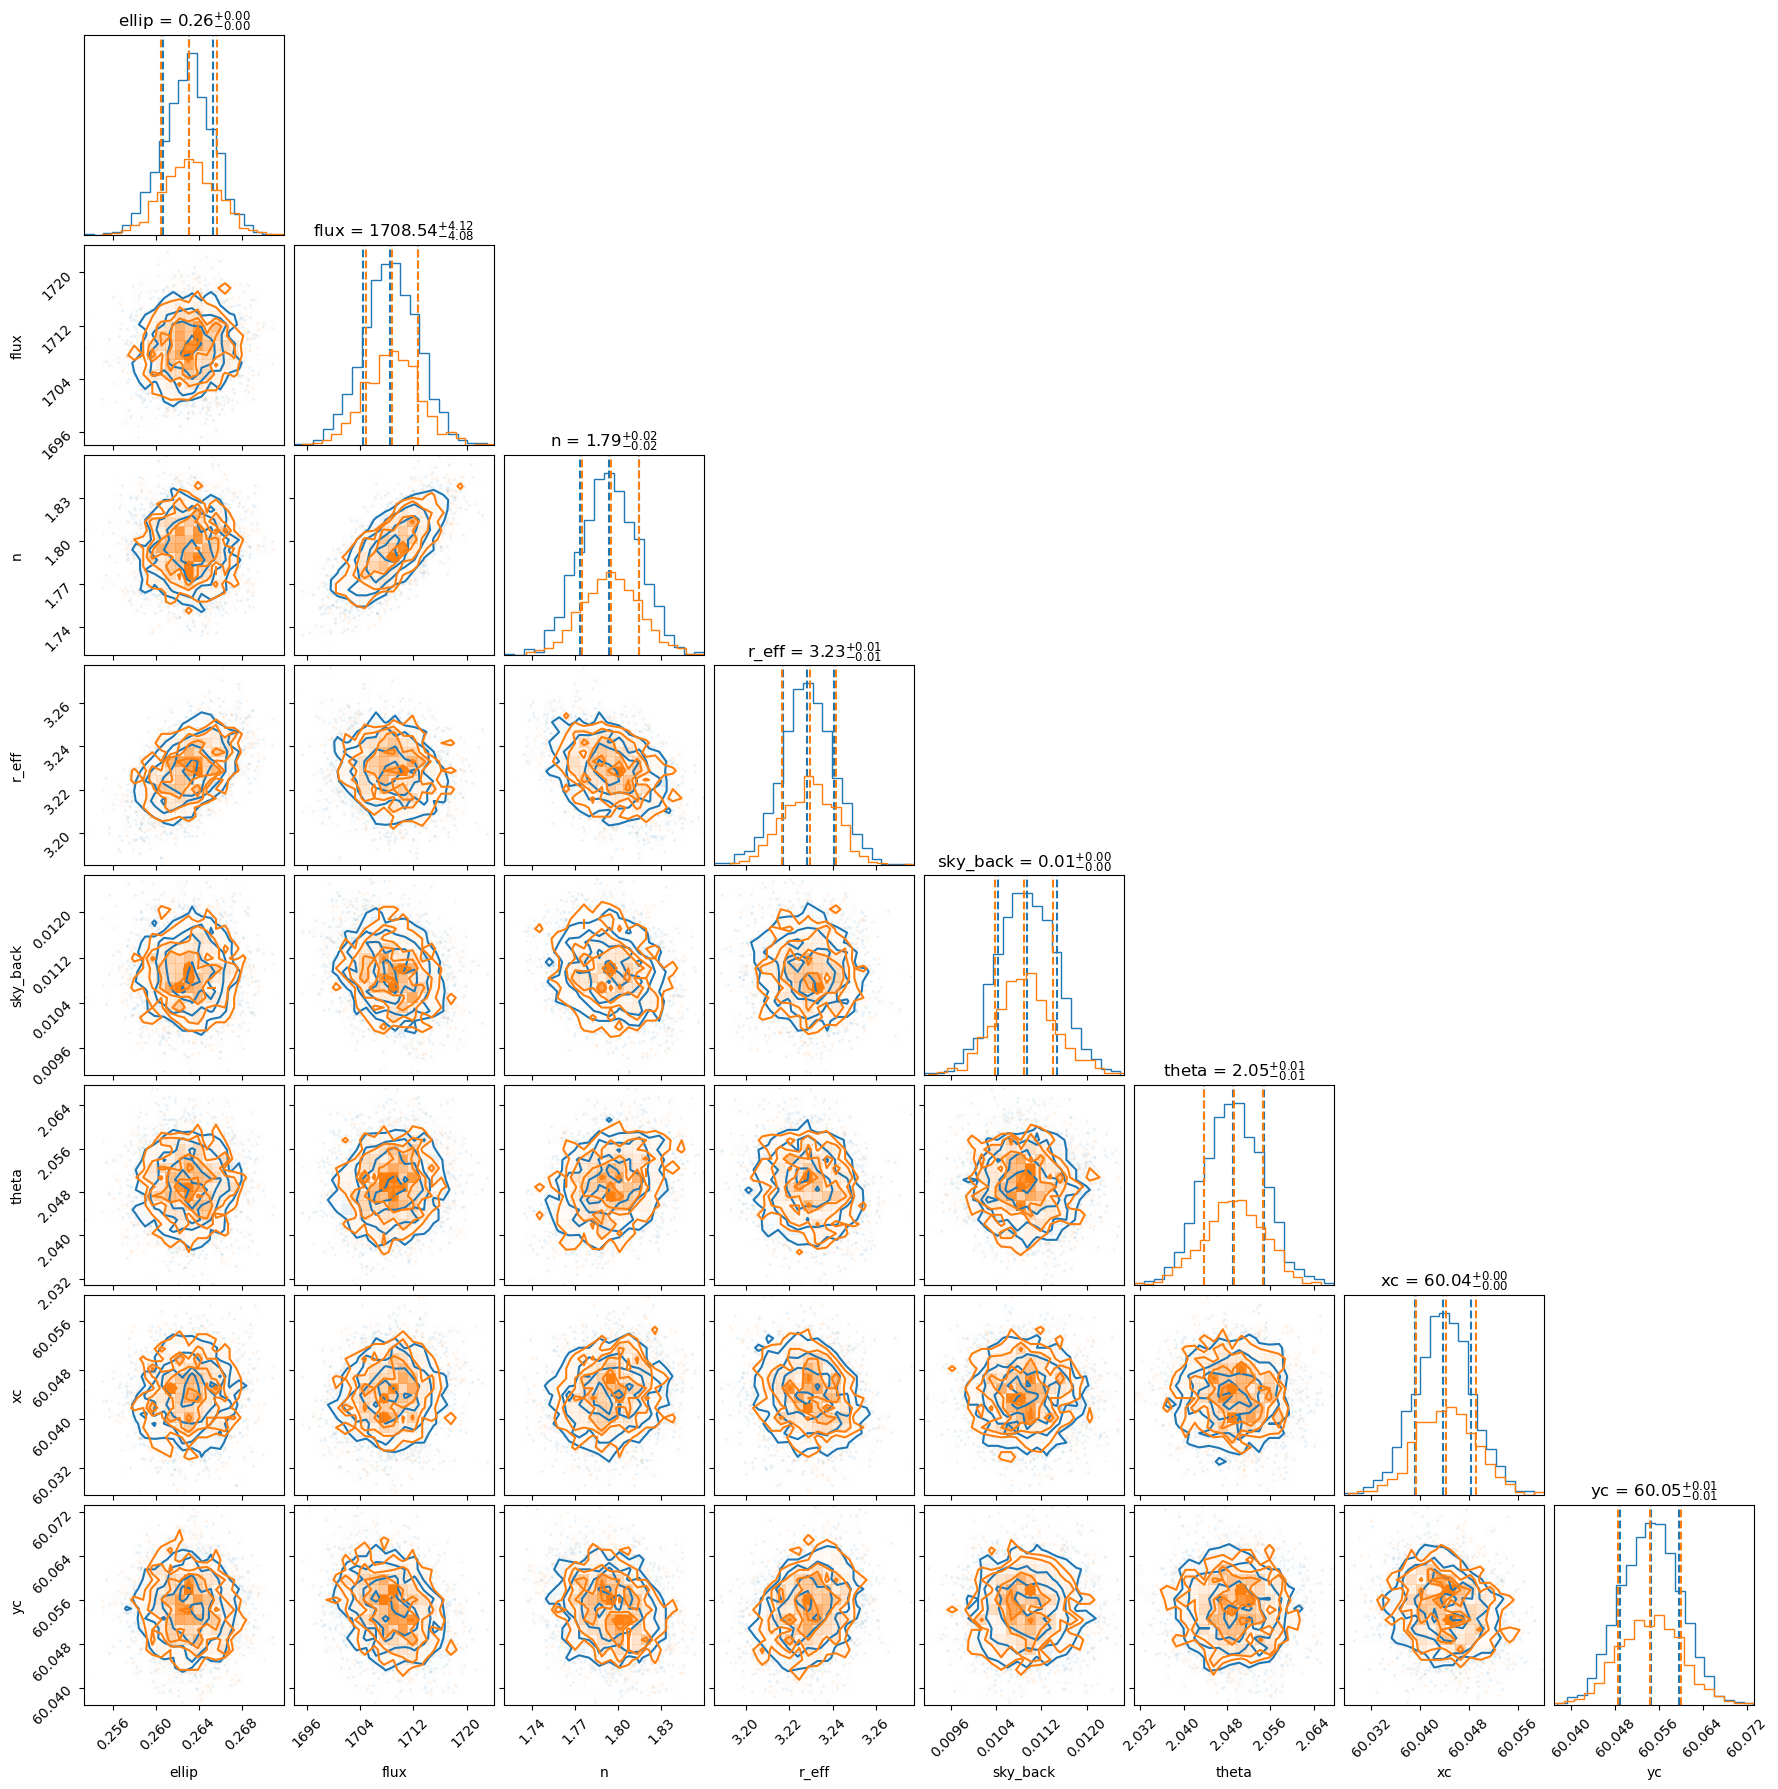

In [18]:
import corner 
fig = fitter.sampling_results.corner(color='C0') 
fig = corner.corner(fitter.svi_results.idata,quantiles=[.16,.5,.84],color='C1',fig=fig)


If we want to retrieve a table with arbitrary quantiles for a fit, we can use the `retrieve_param_quantiles()` function. This will return either a dictionary (if `return_dataframe=False`) or a data frame, with the requested quantiles as columns and the parameters as rows.

In [19]:
fitter.svi_results.retrieve_param_quantiles(return_dataframe=True)

0.16         0.50         0.84
ellip        0.260516     0.263085     0.265731
flux      1704.814985  1708.812073  1712.610654
n            1.774303     1.794752     1.814448
r_eff        3.216382     3.229433     3.241482
sky_back     0.010382     0.010885     0.011411
theta        2.043721     2.049275     2.054714
xc          60.039396    60.044304    60.049186
yc          60.048603    60.054476    60.060111

In [20]:
fitter.svi_results.retrieve_param_quantiles(return_dataframe=False)

{'ellip': [0.26051583409309387, 0.26308533549308777, 0.26573060274124144],
 'flux': [1704.8149853515624, 1708.8120727539062, 1712.610654296875],
 'n': [1.77430251121521, 1.794751763343811, 1.8144479036331176],
 'r_eff': [3.2163820266723633, 3.2294329404830933, 3.2414815425872803],
 'sky_back': [0.010381669513881206,
  0.010884859599173069,
  0.011410721130669117],
 'theta': [2.0437211418151855, 2.0492751598358154, 2.0547141647338867],
 'xc': [60.03939590454102, 60.04430389404297, 60.04918640136719],
 'yc': [60.048603210449215, 60.05447578430176, 60.060110626220705]}

As a note, the default returned quantiles are `[0.16, 0.5, 0.84]` but you can specify any quantiles you wish to the method. The same syntax above will work with the `fitter.sampling_results` as well --- they are the same underlying class.

In [21]:
fitter.sampling_results.retrieve_param_quantiles(return_dataframe=True)

0.16         0.50         0.84
ellip        0.260645     0.263043     0.265299
flux      1704.461245  1708.540405  1712.663433
n            1.773107     1.793609     1.814397
r_eff        3.217026     3.228214     3.240372
sky_back     0.010435     0.010948     0.011472
theta        2.043701     2.049208     2.054808
xc          60.039150    60.043835    60.048356
yc          60.049007    60.054491    60.059748

We can also print out a latex-ready table (using the AAStex deluxetable), if we would so like (the data portion of the table is easily copy-able to other formats).

In [22]:
fitter.sampling_results.latex_table()

\begin{deluxetable}{lr}[b]
\tablehead{
\colhead{Parameter} & \colhead{\hspace{4.5cm}Value\hspace{.5cm}}}
\caption{Best Fit Parameters for Pysersic Fit}
\startdata 
ellip & 0.263_{-0.002}^{+0.002} \\ 
flux & 1708.540_{-4.079}^{+4.123} \\ 
n & 1.794_{-0.021}^{+0.021} \\ 
r_{\rm eff} & 3.228_{-0.011}^{+0.012} \\ 
sky_{\rm back} & 0.011_{-0.001}^{+0.001} \\ 
\theta & 2.049_{-0.006}^{+0.006} \\ 
xc & 60.044_{-0.005}^{+0.005} \\ 
yc & 60.054_{-0.005}^{+0.005} \\ 
\enddata 
\end{deluxetable}


We can also use any callable `func` on any parameter via the following:

In [23]:
ellip_std = fitter.sampling_results.compute_statistic(parameter='ellip',func=np.std)
ellip_std

array(0.00235785, dtype=float32)

Finally, if we just want to yank the chains and start doing our own thing with them, note that the results object has an attribute `.idata` which is an `arviz.InferenceData` object, so it can be slotted into many analyses. We do have a handy function for extracting the chains for each parameter, though:

In [24]:
sampling_chain = fitter.svi_results.get_chains()
sampling_chain['n']

<xarray.DataArray 'n' (sample: 1000)>
array([1.8074653, 1.8016487, 1.820597 , 1.7938645, 1.8146214, 1.8283725,
       1.8429862, 1.7878957, 1.7958227, 1.7912399, 1.7824603, 1.8339493,
       1.7706356, 1.8180473, 1.7923172, 1.7639601, 1.7959906, 1.7809136,
       1.7939559, 1.8206875, 1.8143445, 1.8049928, 1.7764301, 1.8124888,
       1.8012055, 1.7783476, 1.7932078, 1.8435104, 1.8026671, 1.8061337,
       1.7639052, 1.8057855, 1.7768195, 1.7990735, 1.780491 , 1.8065754,
       1.7957149, 1.7917581, 1.7928663, 1.7795041, 1.8329585, 1.7611268,
       1.7653506, 1.8040394, 1.7743065, 1.7800122, 1.7818632, 1.8011379,
       1.7831267, 1.8226411, 1.8073732, 1.784469 , 1.8447931, 1.804879 ,
       1.7801017, 1.7938635, 1.7789272, 1.8101755, 1.7910978, 1.7893214,
       1.776124 , 1.7866921, 1.8017458, 1.803878 , 1.7615288, 1.7966291,
       1.8026252, 1.8250465, 1.7593013, 1.8269323, 1.792949 , 1.8013291,
       1.8120519, 1.8024907, 1.7601913, 1.8019806, 1.778777 , 1.784775 ,
       1.796636 , 1.7881457, 1.8081787, 1.7800685, 1.7929348, 1.8099376,
       1.769849 , 1.7864577, 1.7952504, 1.8213816, 1.8115224, 1.8202558,
       1.783077 , 1.7680776, 1.7852225, 1.8028789, 1.827084 , 1.8094846,
       1.8360202, 1.8020216, 1.8074841, 1.8147359, 1.8058822, 1.7625898,
       1.7837851, 1.8193705, 1.7863106, 1.7686582, 1.8378853, 1.8171486,
       1.765147 , 1.7973694, 1.8343729, 1.7651565, 1.821569 , 1.7705649,
       1.8054991, 1.7756064, 1.7947572, 1.7702191, 1.7758436, 1.7837615,
...
       1.8026625, 1.7832416, 1.8322232, 1.8152299, 1.7793359, 1.7679663,
       1.8127165, 1.7942051, 1.8106079, 1.8307188, 1.7700677, 1.8172432,
       1.7714213, 1.7788298, 1.8124458, 1.781001 , 1.7710315, 1.7794046,
       1.8433225, 1.839494 , 1.7995455, 1.7886708, 1.8054208, 1.7592269,
       1.8154671, 1.7949835, 1.7859321, 1.7977208, 1.7762707, 1.8074918,
       1.7909604, 1.8052588, 1.8014445, 1.7814071, 1.7841086, 1.785013 ,
       1.824086 , 1.7763957, 1.7878629, 1.8123567, 1.7914456, 1.8254114,
       1.7929736, 1.8101741, 1.8091799, 1.8213991, 1.8114986, 1.8006737,
       1.7991364, 1.8054523, 1.79507  , 1.7954153, 1.817134 , 1.7821898,
       1.7932994, 1.7528783, 1.7686845, 1.834658 , 1.7733222, 1.8036867,
       1.8056659, 1.7861767, 1.7634968, 1.8107764, 1.7716249, 1.7497028,
       1.7759869, 1.7603137, 1.8152207, 1.7786349, 1.7774704, 1.8070872,
       1.7600038, 1.8069513, 1.8140125, 1.7846954, 1.8109375, 1.7700608,
       1.7609917, 1.7992171, 1.7722943, 1.794279 , 1.8112442, 1.7893518,
       1.7847164, 1.7986282, 1.8110514, 1.7923195, 1.8047088, 1.7880011,
       1.784782 , 1.795546 , 1.7569072, 1.7860161, 1.8036404, 1.7990258,
       1.8002484, 1.783118 , 1.7887274, 1.7475039, 1.7985098, 1.8121568,
       1.810106 , 1.8296282, 1.8216062, 1.806106 , 1.8044084, 1.7885362,
       1.8037161, 1.8023309, 1.7611327, 1.8121418, 1.789502 , 1.7853181,
       1.8031127, 1.8236066, 1.7828134, 1.7610044], dtype=float32)
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

There are many more things we can do in terms of carrying out statistics on our outputs -- but since `arviz` has its own, well-vetted system for that, we trust that you can grab the `arviz` inference data objects (`fitter.svi_results.idata` and `fitter.sampling_results.idata`) and run with them as needed, inserting them into other analyses.



## Saving the fit to a file 

Lastly, we may want to save the parameters of our fit (info, chains, models, data) to a file. This can be done with the `results.save_results()` method:

As we can see, the information needed to reconsitute the models and fit parameters are all stored in this file. The `'input_data'` dictionary in the tree contains a copy of the data that was fit. We can see which loss function and renderer was used. We can also access our prior printout:

In [25]:
fitter.sampling_results.save_result('example_fit.asdf')

We can (presumably at a later time) then load our asdf file and view what it contains:

In [26]:
import asdf 
af = asdf.open('example_fit.asdf')
af.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.14.3
├─history (dict)
│ └─extensions (list) ...
├─best__model (NDArrayType): shape=(121, 121), dtype=float32
├─contains_SVI_result (bool): False
├─contains_sampling_result (bool): True
├─input_data (dict)
│ ├─image (NDArrayType): shape=(121, 121), dtype=float32
│ ├─mask (NDArrayType): shape=(121, 121), dtype=bool
│ ├─psf (NDArrayType): shape=(121, 121), dtype=float32
│ └─rms (NDArrayType): shape=(121, 121), dtype=float32
├─loss_func (str): <function student_t_loss at 0x7fa6a10d2680>
├─posterior (dict)
│ ├─ellip (NDArrayType): shape=(2, 1000), dtype=float32
│ ├─flux (NDArrayType): shape=(2, 1000), dtype=float32
│ └─6 not shown
├─prior_info (str): Prior for a sersic source:
--------------------------
flux ---  Normal w (truncated)
└─renderer (str): <pysersic.rendering.HybridRenderer object at 0x7fa6a21625f0>
Som

As we can see, everything we need, from the input data, to which loss function, to the prior info, and finally the posterior chains, are stored in this file. For example, to see what our priors were:

In [27]:
print(af.tree['prior_info'])

Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 1909.80, sigma = 87.40
r_eff ---  Truncated Normal w/ mu = 7.02, sigma = 2.65, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Custom prior of type: <class 'numpyro.distributions.directional.VonMises'>
n ---  Truncated Normal w/ mu = 2.00, sigma = 1.00, between: 0.50 -> 8.00
xc ---  Normal w/ mu = 60.02, sigma = 1.00
yc ---  Normal w/ mu = 60.06, sigma = 1.00



And finally, the posterior chains for the fits are in the `'svi_posterior'` and `'sampling_posterior'` dictionaries within the tree. As a result, we can quickly re-constitute a corner plot:

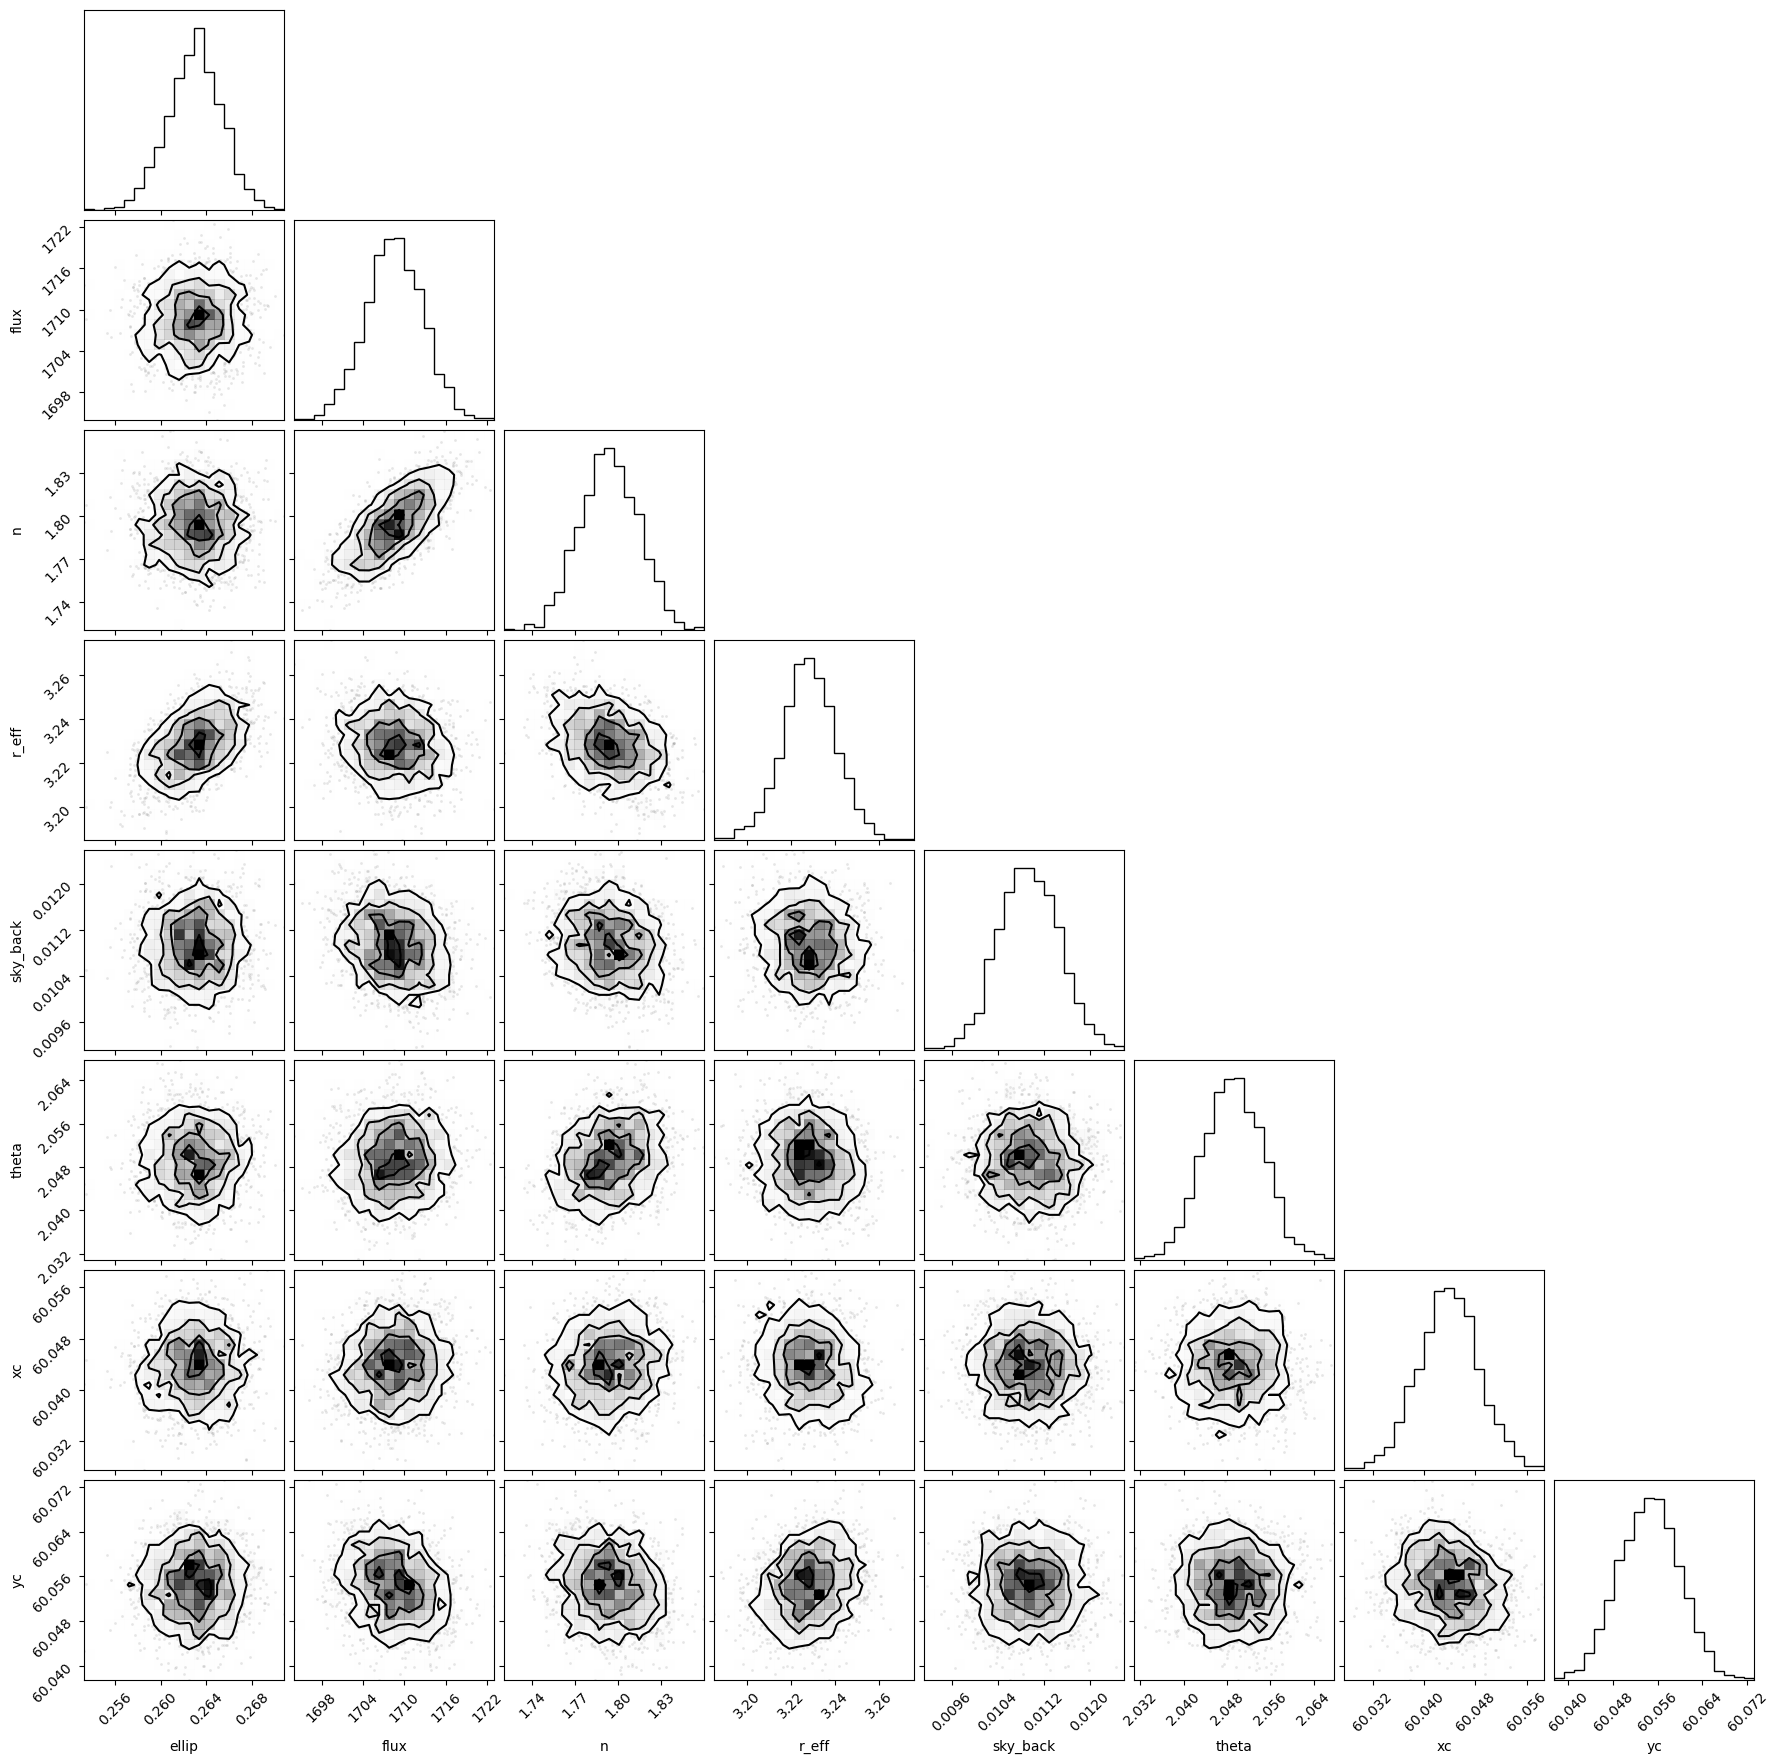

In [29]:
import corner 
fig = corner.corner(af.tree['posterior'])